In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sms
import scipy.stats as ss
import plotly.express as px
import statsmodels.api as sm
import pylab

from matplotlib.ticker import FuncFormatter
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu
from datetime import datetime

%matplotlib inline
plt.style.use('ggplot')

# Вариант 1

Задание 1. 

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать 
retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

In [2]:
reg_data   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sazanov-25/shared/problem1-reg_data.csv', sep=';')
auth_data   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sazanov-25/shared/problem1-auth_data.csv', sep=';')

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.shape

(1000000, 2)

In [5]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
reg_data.isna().value_counts()

reg_ts  uid  
False   False    1000000
dtype: int64

In [7]:
reg_data.duplicated().sum()

0

In [8]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth_data.shape

(9601013, 2)

In [10]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [11]:
auth_data.isna().value_counts() 

auth_ts  uid  
False    False    9601013
dtype: int64

In [12]:
auth_data.duplicated().sum()

0

In [13]:
df = reg_data.merge(auth_data, on=['uid'])
df = df.reindex(columns=['uid','reg_ts','auth_ts'])
df.head()

,uid,reg_ts,auth_ts
0,1,911382223,911382223
1,2,932683089,932683089
2,2,932683089,932921206
3,2,932683089,933393015
4,2,932683089,933875379


In [14]:
df['reg_ts'] = df['reg_ts'].apply(datetime.fromtimestamp)
df['auth_ts'] = df['auth_ts'].apply(datetime.fromtimestamp)

In [15]:
df_ready = df

In [16]:
df_ready.head()

,uid,reg_ts,auth_ts
0,1,1998-11-18 12:43:43,1998-11-18 12:43:43
1,2,1999-07-23 02:38:09,1999-07-23 02:38:09
2,2,1999-07-23 02:38:09,1999-07-25 20:46:46
3,2,1999-07-23 02:38:09,1999-07-31 07:50:15
4,2,1999-07-23 02:38:09,1999-08-05 21:49:39


In [17]:
df_ready.reg_ts.min()

Timestamp('1998-11-18 12:43:43')

In [18]:
df_ready.auth_ts.min()

Timestamp('1998-11-18 12:43:43')

In [19]:
df_ready.reg_ts.max()

Timestamp('2020-09-23 18:17:24')

In [20]:
df_ready.auth_ts.max()

Timestamp('2020-09-23 18:17:24')

Выводы после обработки данных:
1. Дубликатов, нулевых значений в данных нет
2. Время переведено в корректный формат
3. Имеем данные с 1998-11-18 12:43:43 по 2020-09-23 18:17:24. Причем первая/последняя регистрация = первой/последней авторизации

Данные в одном df, теперь с ними можно работать 

Проверяем, сколько регистраций было в каждом году

In [21]:
df_ready['reg_year'] = df_ready['reg_ts'].values.astype('datetime64[Y]')
df_ready['reg_year'] = df_ready['reg_year'].dt.year
reg_year = df_ready.groupby('reg_year', as_index=False).agg({'uid':'nunique'})

In [22]:
reg_year

,reg_year,uid
0,1998,1
1,1999,1
2,2000,4
3,2001,6
4,2002,10
5,2003,20
6,2004,35
7,2005,65
8,2006,119
9,2007,216


Функция для  использования:

In [23]:
 def retention_rate(data, start, finish):

    # Добавляем фильтр
    df_rr = df_ready.query("reg_ts > = @start and auth_ts <= @finish")
    df_rr['reg_date'] = pd.to_datetime(df_rr['reg_ts'].dt.date)
    df_rr['auth_date'] = pd.to_datetime(df_rr['auth_ts'].dt.date)
    df_rr = df_rr.drop(['reg_ts', 'auth_ts'], axis=1)  
    
    # Добавляем столбец с дельтой (кол-во дней с даты регистрации)
    df_rr['life_time'] = df_rr['auth_date'] - df_rr['reg_date']
           
    # Вычесляем retention с группировкой по дате регистрации, заполняем пропуски, округляем.
    retention = df_rr.pivot_table(index='reg_date', columns='life_time', values='uid', aggfunc = 'nunique')
    
    # Заполняем пропуски, добавляем округление до 3 знаков
    retention = retention.divide(retention.iloc[:,0],axis='index').iloc[:-1, 1:].fillna(0).round(3)

    # Добавляем Визуализацию
    plt.figure(figsize=(20, 15))
    ax = sns.heatmap(retention, cmap="YlGnBu", annot=True, fmt=".1%", vmax=0.1, xticklabels = retention.columns.astype('str'), yticklabels = retention.index.astype('str'))
    ax.set_title(f'''{df_rr['life_time'].max().days} days retention rate''', fontsize=20)
    sns.despine()
        
    return retention

Примеры использования:

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


life_time,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,...,21 days,22 days,23 days,24 days,25 days,26 days,27 days,28 days,29 days,30 days
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.026,0.042,0.043,0.043,0.072,0.072,0.059,0.047,0.043,0.051,...,0.042,0.039,0.027,0.038,0.032,0.039,0.038,0.029,0.033,0.022
2020-01-02,0.024,0.039,0.048,0.048,0.058,0.066,0.066,0.051,0.050,0.063,...,0.035,0.047,0.040,0.036,0.030,0.038,0.035,0.034,0.029,0.000
2020-01-03,0.020,0.041,0.047,0.049,0.066,0.072,0.055,0.049,0.045,0.055,...,0.038,0.036,0.032,0.034,0.035,0.029,0.025,0.028,0.000,0.000
2020-01-04,0.019,0.039,0.050,0.058,0.057,0.066,0.051,0.046,0.045,0.055,...,0.030,0.034,0.032,0.028,0.030,0.032,0.021,0.000,0.000,0.000
2020-01-05,0.018,0.053,0.041,0.048,0.048,0.074,0.054,0.049,0.049,0.042,...,0.042,0.028,0.044,0.033,0.037,0.032,0.000,0.000,0.000,0.000
2020-01-06,0.027,0.046,0.048,0.041,0.058,0.067,0.051,0.050,0.048,0.058,...,0.045,0.043,0.036,0.026,0.037,0.000,0.000,0.000,0.000,0.000
2020-01-07,0.021,0.049,0.045,0.053,0.055,0.089,0.056,0.057,0.055,0.050,...,0.034,0.042,0.041,0.039,0.000,0.000,0.000,0.000,0.000,0.000
2020-01-08,0.022,0.037,0.041,0.048,0.054,0.070,0.059,0.048,0.059,0.040,...,0.038,0.035,0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2020-01-09,0.020,0.043,0.049,0.050,0.057,0.071,0.055,0.053,0.048,0.044,...,0.042,0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


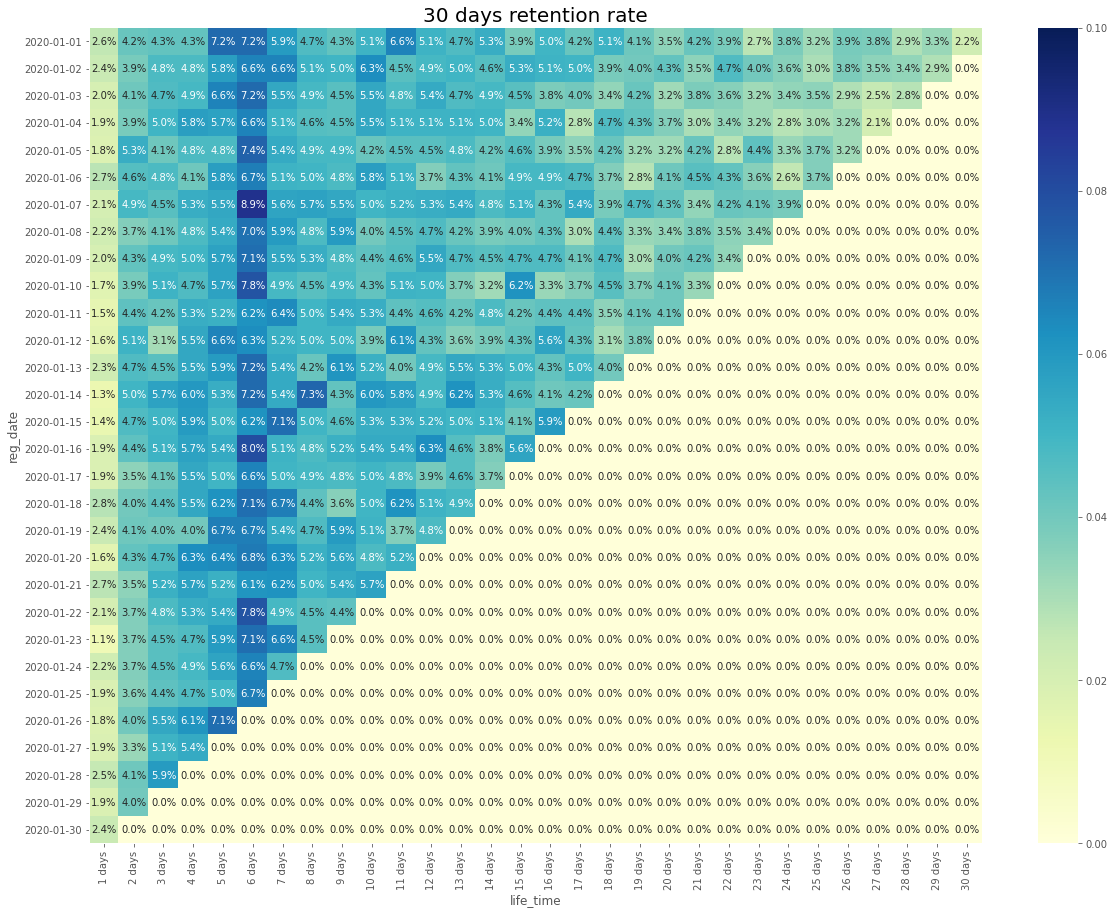

In [24]:
retention_rate(data = df_ready, start = '2020-01-01', finish = '2020-02-01')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


life_time,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,...,19 days,20 days,21 days,22 days,23 days,24 days,25 days,26 days,27 days,28 days
reg_date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.000,0.095,0.000,0.000,0.095,0.000,0.000,0.095,0.143,0.048,...,0.048,0.000,0.095,0.048,0.048,0.000,0.000,0.048,0.000,0.048
2013-07-02,0.000,0.091,0.045,0.000,0.045,0.091,0.045,0.000,0.045,0.045,...,0.045,0.000,0.000,0.000,0.000,0.136,0.000,0.045,0.000,0.000
2013-07-03,0.000,0.000,0.095,0.095,0.048,0.143,0.048,0.095,0.095,0.048,...,0.000,0.095,0.095,0.095,0.095,0.000,0.048,0.095,0.000,0.095
2013-07-04,0.000,0.000,0.045,0.045,0.091,0.091,0.045,0.000,0.000,0.000,...,0.045,0.000,0.045,0.045,0.045,0.045,0.091,0.045,0.045,0.000
2013-07-05,0.000,0.000,0.048,0.095,0.048,0.000,0.095,0.048,0.048,0.000,...,0.095,0.048,0.048,0.095,0.000,0.048,0.000,0.048,0.000,0.000
2013-07-06,0.045,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2013-07-07,0.000,0.000,0.048,0.143,0.048,0.095,0.048,0.095,0.048,0.095,...,0.048,0.190,0.143,0.000,0.095,0.048,0.000,0.000,0.000,0.000
2013-07-08,0.000,0.045,0.000,0.000,0.136,0.136,0.000,0.045,0.000,0.091,...,0.045,0.000,0.136,0.000,0.045,0.000,0.000,0.000,0.000,0.000
2013-07-09,0.000,0.000,0.000,0.045,0.000,0.091,0.091,0.000,0.000,0.091,...,0.091,0.000,0.045,0.000,0.000,0.000,0.000,0.000,0.000,0.000


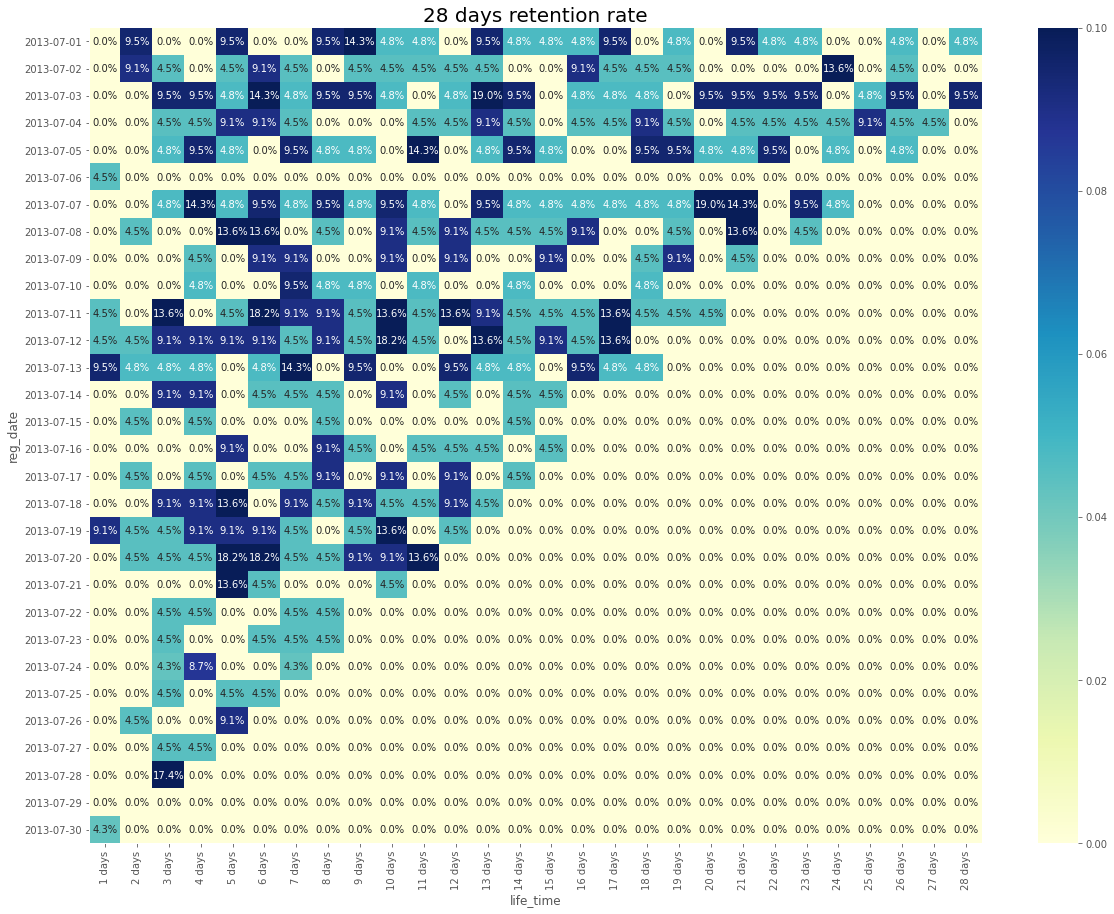

In [25]:
retention_rate(data = df_ready, start = '2013-07-01', finish = '2013-08-01')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


life_time,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,...,21 days,22 days,23 days,24 days,25 days,26 days,27 days,28 days,29 days,30 days
reg_date,,,,,,,,,,,,,,,,,,,,,
2015-03-01,0.017,0.052,0.069,0.086,0.086,0.121,0.069,0.086,0.034,0.103,...,0.017,0.034,0.086,0.034,0.069,0.034,0.034,0.052,0.052,0.017
2015-03-02,0.017,0.103,0.000,0.086,0.034,0.103,0.034,0.034,0.000,0.069,...,0.017,0.017,0.034,0.034,0.034,0.052,0.000,0.069,0.000,0.000
2015-03-03,0.000,0.017,0.052,0.034,0.069,0.052,0.034,0.017,0.069,0.034,...,0.000,0.069,0.052,0.017,0.069,0.017,0.052,0.034,0.000,0.000
2015-03-04,0.034,0.068,0.034,0.017,0.085,0.051,0.034,0.034,0.051,0.068,...,0.051,0.051,0.034,0.000,0.034,0.017,0.102,0.000,0.000,0.000
2015-03-05,0.034,0.034,0.034,0.052,0.052,0.034,0.052,0.034,0.034,0.069,...,0.000,0.034,0.069,0.000,0.000,0.034,0.000,0.000,0.000,0.000
2015-03-06,0.034,0.034,0.136,0.034,0.102,0.085,0.034,0.068,0.102,0.051,...,0.051,0.034,0.051,0.068,0.017,0.000,0.000,0.000,0.000,0.000
2015-03-07,0.034,0.017,0.000,0.052,0.052,0.052,0.052,0.052,0.017,0.017,...,0.086,0.017,0.017,0.017,0.000,0.000,0.000,0.000,0.000,0.000
2015-03-08,0.034,0.068,0.034,0.085,0.068,0.136,0.034,0.034,0.017,0.068,...,0.034,0.051,0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2015-03-09,0.068,0.034,0.017,0.051,0.068,0.153,0.034,0.085,0.068,0.068,...,0.034,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


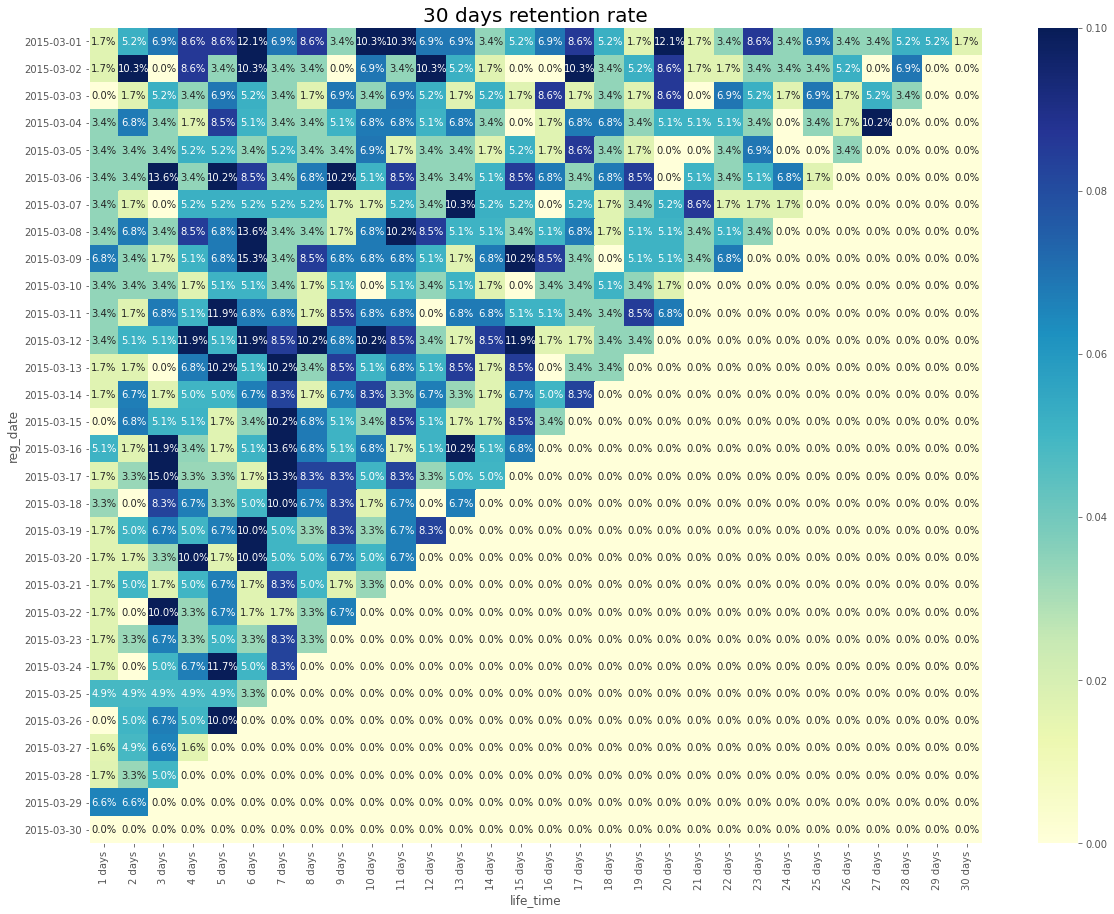

In [26]:
retention_rate(data = df_ready, start = '2015-03-01', finish = '2015-04-01')

Итого:

1. Данные выглядят странно/ненатурально, до 2014 года - совсем хаотично из-за небольшого количества пользователей
2. Зависимость определить сложно, но в последние годы просматривается тенденция к тому, что
самый высокий показатель retention в среднем - 6 день
3. Если посмотреть в целом, то показатель возвращаемости игроков низкий, нужно над этим работать

Задание 2. 

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [27]:
df_ab = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sazanov-25/Проект_1_Задание_2.csv', sep=';')
df_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [28]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [29]:
df_ab.isna().value_counts() 

user_id  revenue  testgroup
False    False    False        404770
dtype: int64

In [30]:
df_ab.duplicated().sum()

0

In [31]:
df_ab.user_id.nunique()

404770

In [32]:
df_ab.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [33]:
df_ab.query('testgroup == "a"').describe().round(0)

,user_id,revenue
count,202103.0,202103.0
mean,202556.0,25.0
std,116802.0,921.0
min,2.0,0.0
25%,101502.0,0.0
50%,202988.0,0.0
75%,303559.0,0.0
max,404769.0,37433.0


In [34]:
df_ab.query('testgroup == "b"').describe().round(0)

,user_id,revenue
count,202667.0,202667.0
mean,202216.0,27.0
std,116892.0,287.0
min,1.0,0.0
25%,100856.0,0.0
50%,201821.0,0.0
75%,303602.0,0.0
max,404770.0,4000.0


Выводы после обработки данных:

1. Дубликатов, нулевых значений в данных нет, уникальных пользователей 404770
2. Есть 2 группы: "a" - контрольная на 202103 пользователей, "b" - тестовая на 202667
3. По тестовым группам есть стат. показатели, которые в целом схожи, кроме стандартного отклонения для revenue

Посчитаем и посмотрим на основные метрики

Найдем количество платящих пользователей в каждой группе 

In [35]:
group_a = df_ab.query('testgroup == "a"')
group_b = df_ab.query('testgroup == "b"')

a_revenue = df_ab.query('testgroup == "a" & revenue > 0')
b_revenue = df_ab.query('testgroup == "b" & revenue > 0')

a_revenue_sum = group_a.revenue.sum()
b_revenue_sum = group_b.revenue.sum()

a_count = group_a.user_id.shape[0]
b_count = group_b.user_id.shape[0]

a_pay = a_revenue.revenue.shape[0]
b_pay = b_revenue.revenue.shape[0]

Найдем конверсию

In [36]:
a_conv = round(a_pay / a_count * 100,2)
b_conv = round(b_pay / b_count * 100,2)

Найдем средний (+медиану), максимальный и минимальный чек

In [37]:
a_avg_revenue = a_revenue.revenue.mean()
b_avg_revenue = b_revenue.revenue.mean()
   
a_median_revenue = a_revenue.revenue.median()
b_median_revenue = b_revenue.revenue.median()

a_max_revenue = group_a.revenue.max()
b_max_revenue = group_b.revenue.max()

a_min_revenue = a_revenue.revenue.min()
b_min_revenue = b_revenue.revenue.min()

Найдем средний доход на одного пользователя / платящего пользователя

In [38]:
a_ARRPU = round(a_revenue_sum / a_pay)
b_ARRPU = round(b_revenue_sum / b_pay)

a_ARPU = round(a_conv * a_ARRPU)
b_ARPU = round(b_conv * b_ARRPU)

Посмотрим на метрики в таблице

In [39]:
metrics = pd.DataFrame({'users': [a_count, b_count],
              'pay_users': [a_pay, b_pay],
              'conv_rate':[a_conv, b_conv],
              'avg_revenue':[a_avg_revenue, b_avg_revenue],
              'median_revenue':[a_median_revenue, b_median_revenue],
              'max_revenue':[a_max_revenue, b_max_revenue],
              'min_revenue':[a_min_revenue, b_min_revenue],
              'ARPPU':[a_ARRPU, b_ARRPU],
              'ARPU':[a_ARPU, b_ARPU],
              'sum_revenue':[a_revenue_sum, b_revenue_sum]},
index=['a_control', 'b_test'])

metrics

,users,pay_users,conv_rate,avg_revenue,median_revenue,max_revenue,min_revenue,ARPPU,ARPU,sum_revenue
a_control,202103,1928,0.95,2663.998444,311.0,37433,200,2664,2531,5136189
b_test,202667,1805,0.89,3003.658172,3022.0,4000,2000,3004,2674,5421603


Выводы после осмотра таблицы метрик:

Между группами "b" и "a"
1. Конверсия снизилась на 6%
2. Средний доход вырос на ~ 15%, но медианный средний чек вырос аж в ~10 раз
3. Максимальный чек - упал в ~10 раз, минимальный - вырос в ~10 раз
4. APRU вырос на ~5% (как и было указано в условиях)

Посмотрим графики

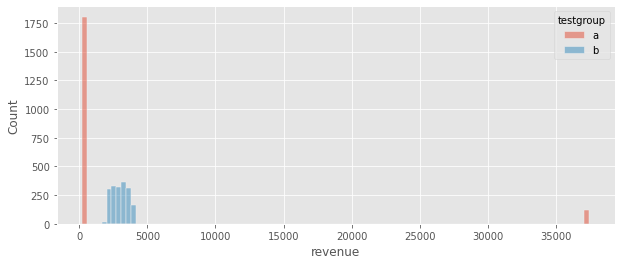

In [40]:
plt.figure(figsize=(10, 4))
sns.histplot(x = 'revenue', data = df_ab.query('revenue != 0'), hue = 'testgroup')

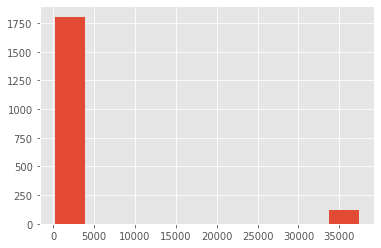

In [41]:
df_ab.query('testgroup == "a" and revenue > 0')['revenue'].hist()

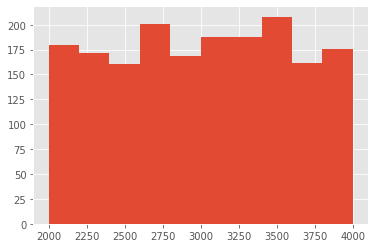

In [42]:
df_ab.query('testgroup == "b" and revenue > 0')['revenue'].hist()

Рассмотрим выбросы группы "a"

In [43]:
df_ab[df_ab.testgroup == "a"].query('revenue > 5000').user_id.count()

123

In [44]:
round(df_ab.query('testgroup == "a" & revenue > 5000').revenue.sum()
/df_ab.query('testgroup == "a" & revenue > 0').revenue.sum()*100,1)

89.4

Выводы после осмотра графиков и выбросов:

1. Между группами "a" и "b" есть сильные различия
2. Распределения обоих групп ненормальное
3. В группе "a" есть две подгруппы с очень низким (<2000) и очень высоким (>5000) чеком, поэтому в таблице были такие расхождения
4. В группе "а" есть 123 пользователя, которые составляют почти 90% от всего дохода
5. В группе "b" нет ни одного пользователя с чеком больше 4000

Проверим нормальность распределения с помощью normaltest и гомогенность дисперсий с помощью критерия Левина

In [45]:
stats.normaltest(a_revenue.revenue) 

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [46]:
stats.normaltest(b_revenue.revenue) 

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

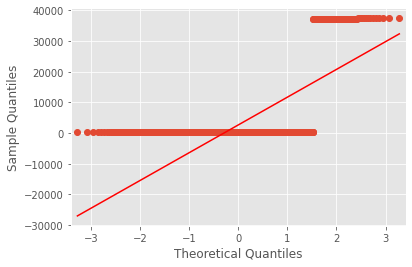

In [47]:
sm.qqplot(a_revenue.revenue, line = 's')
pylab.show()

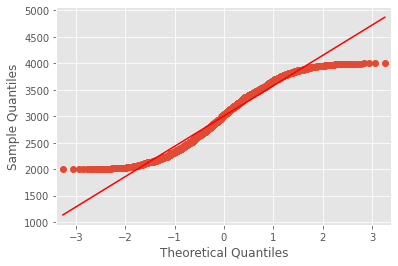

In [48]:
sm.qqplot(b_revenue.revenue, line = 's')
pylab.show()

In [49]:
stats.levene(a_revenue.revenue, b_revenue.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Выводы по levene:

1. Подтверждаем, что распределение ненормальное
2. P-value < 0.05. Нулевую гипотезу отклоняем, дисперсия негомогенна

Проверим стат. различия между выборками с помощью критерия Манна-Уитни

In [50]:
mannwhitneyu(df_ab[df_ab.testgroup == "a"].revenue,
             df_ab[df_ab.testgroup == "b"].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [51]:
mannwhitneyu(df_ab[df_ab.testgroup == "a"].query('revenue > 0').revenue,
             df_ab[df_ab.testgroup == "b"].query('revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Выводы по Манна-Уитни:
1. p-value для неплатящих пользователей >0.05. Нулевую гипотезу о различии между выборками не отклоняем
2. p-value для платящих пользователей <0.05. Статистические различия есть, поэтому окончательные выводы сделать не можем (дабы не совершить ошибку 1-го рода)

Проверим стат. различия между выборками с помощью bootstrap

In [52]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [53]:
a_ARPU_bs = group_a.revenue
b_ARPU_bs = group_b.revenue

a_ARPPU_bs = a_revenue.revenue
b_ARPPU_bs = b_revenue.revenue

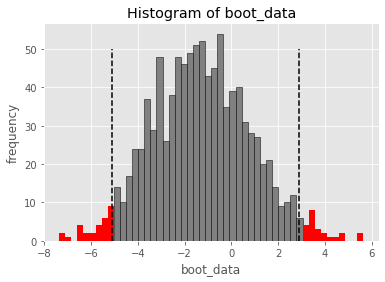

In [54]:
ARPU_bs = get_bootstrap(a_ARPU_bs, b_ARPU_bs,
                                 boot_it = 1000,
                                 statistic = np.mean)

In [55]:
ARPU_bs["p_value"] 

0.5377748442034016

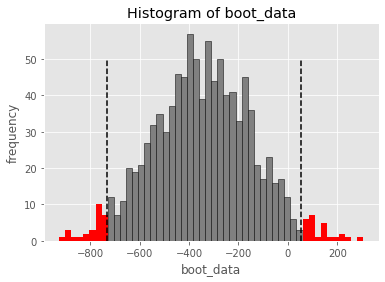

In [56]:
ARPPU_bs = get_bootstrap(a_ARPPU_bs, b_ARPPU_bs,
                                 boot_it = 1000,
                                 statistic = np.mean)

In [57]:
ARPPU_bs["p_value"] 

0.08280150828862409

Выводы по bootstrap:
1. ARPU p-value >0.05, 0 находится в дов. интервале. Стат. различий нет
2. ARPPU p-value >0.05, 0 находится в дов. интервале. Стат. различий нет

Итого:
1. Между контрольной и тестовой группой нет стат. различия
2. Имеются различия в размере ср. чека: в контрольной большой перекос по макс. и мин. чеку - почти 90% выручки приносят 123 пользователя, тогда акак в тестовой - средний чек 2000-4000. 

Что лучше? Вопросы открытый
1. Группа "а" подразумевает работу с двумя типами пользователей, между которами пропасть. Естественно, большй упор придется делать на богатых клиентов - это удержание, вип программы и прочее. Каждый такой потерянный клиент - удар для компании.
2. Группа "b" подразумевает более стабильную модель со средним чеком. Все клиенты примерно равны, подход работы к ним - схож. Потеря клиента не будет катастрофой для компании

Я бы предпочел вариант №2, т.к. он менее рискованный и, вероятно, затратный, т.к. не придется разделять своих пользователей на две абсолютно разные группы и всю свою деятельность фокуксировать на "среднем" покупателе

Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Метрики основные:
- D/W/M AU - анализ динамики заинтересованности пользователей в дни с тематическими событиями (далее ТС)
- Conversion - анализ влияния ТС на конверсию в покупку
- Retention - анализ возвращаемости пользователей в игру во время/после проведения ТС
- Churn rate - анализ негативного влияния на ретеншн
- ARPU/ARPPU - анализ динамики доходности во время/после ТС

Метрики дополнительные:
- Длительность игровых сессий - анализ вовлеченности пользователей в дни ТС и после
- Количество попыток на выполнение уровней - анализ успешности уровней/вовлеченности пользователей
- Отношение пользователей на каждый следующий уровень (воронка) - анализ показателя вовлеченности пользователей и их желания проходить уровни дальше

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Нужно особое внимание уделить Retention/Churn rate, потому что, вероятно, части игрокам это может не понравиться.
Плюс можно усложнить, оценив среднее количество уровней, на которое игроки откатываются в среднем/перед прекращением сессии

Вообще подобные механизмы, основанные на таком негативном подкреплении, как откат по уровням, лучше вводить аккуратно. Например, использовать A/B тест